# 📈Preprocess & Exploring the Data

Importing Libraries

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller


## Extract Historical Financial Data

In [2]:
# Download all tickers at once (example)
tickers = ["TSLA", "BND", "SPY"]
data_all = yf.download(
    tickers,
    start="2015-01-01",
    end="2026-01-15",
    progress=False,
    auto_adjust=False
)

In [3]:
# Flatten columns by joining with underscore
data_all.columns = ['_'.join(col).strip() if col[1] else col[0] for col in data_all.columns.values]

# Reset index to get Date as a column
data_all = data_all.reset_index()

# Now, melt the DataFrame to get long format with ticker column

# Identify variables to keep and to melt
value_vars = [col for col in data_all.columns if col != 'Date']

# Melt all columns except 'Date'
df_long = pd.wide_to_long(
    data_all,
    stubnames=['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'],
    i='Date',
    j='Ticker',
    sep='_',
    suffix='.+'
).reset_index()

# Rename columns properly (optional)
df_long.rename(columns={
    'Adj Close': 'Adj Close',
    'Close': 'Close',
    'High': 'High',
    'Low': 'Low',
    'Open': 'Open',
    'Volume': 'Volume',
}, inplace=True)

In [4]:
# dataframe info 
print(df_long.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8325 entries, 0 to 8324
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       8325 non-null   datetime64[ns]
 1   Ticker     8325 non-null   object        
 2   Adj Close  8325 non-null   float64       
 3   Close      8325 non-null   float64       
 4   High       8325 non-null   float64       
 5   Low        8325 non-null   float64       
 6   Open       8325 non-null   float64       
 7   Volume     8325 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 520.4+ KB
None


In [5]:
# Show first few rows
print(df_long.head())

        Date Ticker  Adj Close      Close       High        Low       Open  \
0 2015-01-02    BND  60.385960  82.650002  82.690002  82.419998  82.430000   
1 2015-01-05    BND  60.561333  82.889999  82.919998  82.699997  82.739998   
2 2015-01-06    BND  60.736671  83.129997  83.379997  83.029999  83.029999   
3 2015-01-07    BND  60.773186  83.180000  83.279999  83.050003  83.139999   
4 2015-01-08    BND  60.678226  83.050003  83.110001  82.970001  83.110001   

    Volume  
0  2218800  
1  5820100  
2  3887600  
3  2433400  
4  1873400  


In [6]:
# Save to CSV
df_long.to_csv("/Users/elbethelzewdie/Downloads/portfolio-optimization/portfolio-optimization/data/raw/financial_data.csv", index=False)

## Data Cleaning and Understanding

### Statistical Summary

In [7]:
price_cols = ['Close', 'Adj Close', 'High', 'Low', 'Open', 'Volume']

for ticker in df_long['Ticker'].unique():
    print(f"\n=== Statistics for {ticker} ===")
    print(df_long.loc[df_long['Ticker'] == ticker, price_cols].describe())



=== Statistics for BND ===
             Close    Adj Close         High          Low         Open  \
count  2775.000000  2775.000000  2775.000000  2775.000000  2775.000000   
mean     79.554930    67.325728    79.670032    79.437488    79.558094   
std       5.292935     4.685295     5.279281     5.306550     5.296254   
min      68.040001    59.698601    68.379997    67.989998    68.080002   
25%      74.040001    63.436443    74.155003    73.855000    74.019997   
50%      81.029999    66.492111    81.120003    80.940002    81.010002   
75%      83.570000    71.237358    83.680000    83.440002    83.584999   
max      89.480003    76.068123    89.589996    89.440002    89.550003   

             Volume  
count  2.775000e+03  
mean   4.485148e+06  
std    2.918896e+06  
min    0.000000e+00  
25%    2.172700e+06  
50%    4.175700e+06  
75%    6.043050e+06  
max    3.396300e+07  

=== Statistics for SPY ===
             Close    Adj Close         High          Low         Open  \
count

#### Key Insights from the Statistical Summaries

- Risk differentiation is clear: BND is low-volatility, SPY exhibits moderate market risk, and TSLA shows extreme price variability.

- Volatility increases from bonds to equities: Standard deviation rises significantly from BND → SPY → TSLA.

- Liquidity is strong across all assets, with SPY and TSLA showing especially high trading volumes.

- Dividend effects matter: Adjusted Close differs from Close for BND and SPY but not for TSLA.

- Portfolio diversification is justified: The assets exhibit distinct statistical behaviors, supporting their combined use for risk-return balancing.

- Modeling implication: Returns and volatility-based features will be more informative than raw prices, particularly for TSLA.

### Check for missing values

In [8]:
# Check total missing values per column in the entire DataFrame
print("Missing values per column (full data):")
print(df_long.isna().sum())

Missing values per column (full data):
Date         0
Ticker       0
Adj Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
dtype: int64


### Feature Engineering

##### Daily returns 
For a standalone block (centered):$$\text{daily\_return}_t = \frac{\text{Adj Close}_t - \text{Adj Close}_{t-1}}{\text{Adj Close}_{t-1}}$$

In [9]:
df_new = df_long.copy()

In [10]:
df_new['daily_return'] = df_new['Adj Close'].pct_change()

### Data Normalization

In [11]:
# Scaling features per ticker
features_to_scale = [
    "Open", "High", "Low", "Close", "Adj Close", "Volume", "daily_return"
]

df_scaled = df_new.copy()

# Dictionary to store scalers for each ticker (for inverse transform later)
scalers = {}

# List to collect scaled DataFrames per ticker
scaled_dfs = []

for ticker in df_scaled["Ticker"].unique():
    scaler = MinMaxScaler()
    mask = df_scaled["Ticker"] == ticker
    
    # Scale features for this ticker only
    scaled_values = scaler.fit_transform(df_scaled.loc[mask, features_to_scale])
    
    # Create a DataFrame with scaled columns
    scaled_df = pd.DataFrame(
        scaled_values,
        columns=[col + "_scaled" for col in features_to_scale],
        index=df_scaled.loc[mask].index
    )
    
    # Combine with Date and Ticker columns (keep for context)
    scaled_df["Date"] = df_scaled.loc[mask, "Date"]
    scaled_df["Ticker"] = ticker
    
    # Append this ticker's scaled DataFrame to the list
    scaled_dfs.append(scaled_df)
    
    # Store the scaler for potential inverse transforms later
    scalers[ticker] = scaler

# Concatenate all tickers back together
final_scaled_df = pd.concat(scaled_dfs)

# Reorder columns: Date, Ticker, scaled features...
final_scaled_df = final_scaled_df[["Date", "Ticker"] + [col + "_scaled" for col in features_to_scale]]

final_scaled_df = final_scaled_df.sort_values(["Ticker", "Date"]).reset_index(drop=True)


In [12]:
# final_scaled_df now contains ONLY Date, Ticker, and scaled columns

print(final_scaled_df.head())

        Date Ticker  Open_scaled  High_scaled  Low_scaled  Close_scaled  \
0 2015-01-02    BND     0.668374     0.674682    0.672727      0.681437   
1 2015-01-05    BND     0.682813     0.685526    0.685781      0.692630   
2 2015-01-06    BND     0.696320     0.707214    0.701165      0.703824   
3 2015-01-07    BND     0.701444     0.702499    0.702098      0.706157   
4 2015-01-08    BND     0.700046     0.694484    0.698368      0.700093   

   Adj Close_scaled  Volume_scaled  daily_return_scaled  
0          0.041990       0.065330                  NaN  
1          0.052704       0.171366             0.593141  
2          0.063415       0.114466             0.593048  
3          0.065645       0.071649             0.569297  
4          0.059844       0.055160             0.546895  


In [13]:
# Verify scaling worked correctly
final_scaled_df.groupby("Ticker")[[c + "_scaled" for c in features_to_scale]].agg(["min", "max"])

Open_scaled      High_scaled      Low_scaled      Close_scaled       \
               min  max         min  max        min  max          min  max   
Ticker                                                                       
BND            0.0  1.0         0.0  1.0        0.0  1.0          0.0  1.0   
SPY            0.0  1.0         0.0  1.0        0.0  1.0          0.0  1.0   
TSLA           0.0  1.0         0.0  1.0        0.0  1.0          0.0  1.0   

       Adj Close_scaled      Volume_scaled      daily_return_scaled       
                    min  max           min  max                 min  max  
Ticker                                                                    
BND                 0.0  1.0           0.0  1.0                 0.0  1.0  
SPY                 0.0  1.0           0.0  1.0                 0.0  1.0  
TSLA                0.0  1.0           0.0  1.0                 0.0  1.0

- Min–Max normalization was applied to all numerical features during the preprocessing stage. This choice was made in anticipation of later using an LSTM-based model for time series forecasting. LSTM networks are sensitive to feature scale and rely on bounded activation functions such as sigmoid and tanh, which perform more effectively when inputs are constrained to a fixed range. Scaling the data to the [0, 1] interval improves numerical stability, supports faster convergence during training, and preserves the relative temporal patterns in the financial time series, making it well-suited for deep learning–based modeling in subsequent stages of the analysis.

In [14]:
# Save to CSV
final_scaled_df.to_csv("/Users/elbethelzewdie/Downloads/portfolio-optimization/portfolio-optimization/data/processed/scaled_financial_data.csv", index=False)

## Exploratory Data Analysis (EDA)

### Visualize Closing Price Over Time

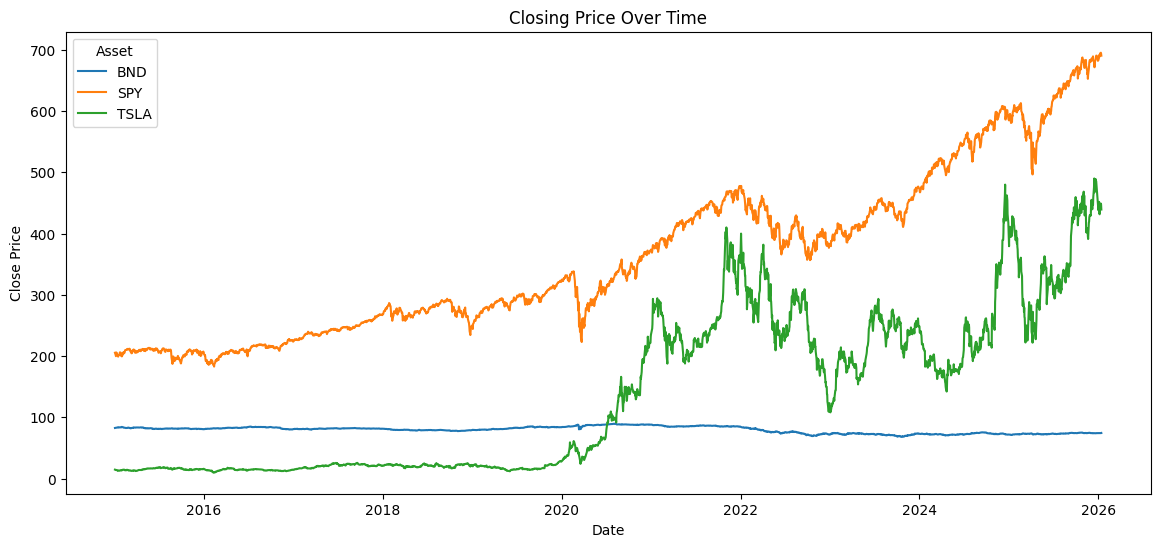

In [15]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_long, x='Date', y='Close', hue='Ticker')
plt.title('Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend(title='Asset')
plt.show()

### Calculate and Plot Daily Percentage Change (Returns) to Observe Volatility

In [16]:
df_long = df_long.sort_values(by=["Ticker", "Date"]).reset_index(drop=True)

df_long["Daily_Return"] = (
    df_long.groupby("Ticker")["Adj Close"]
    .pct_change() * 100
)

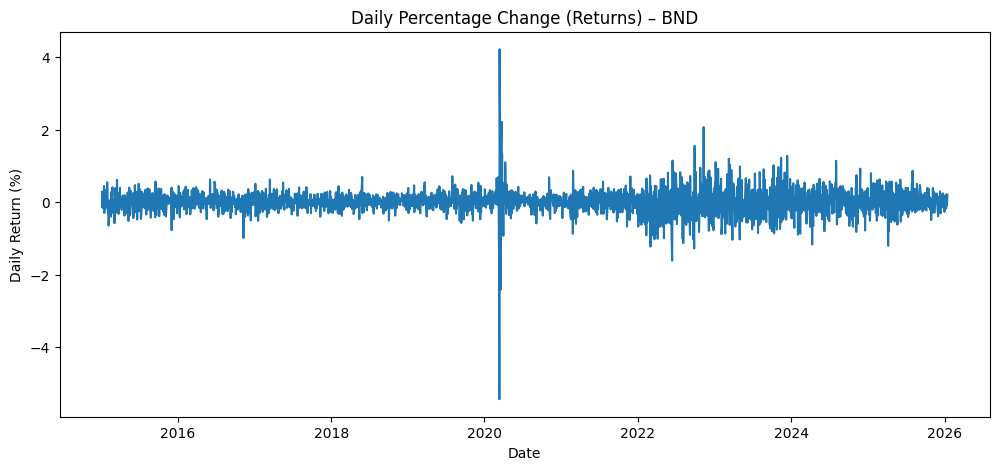

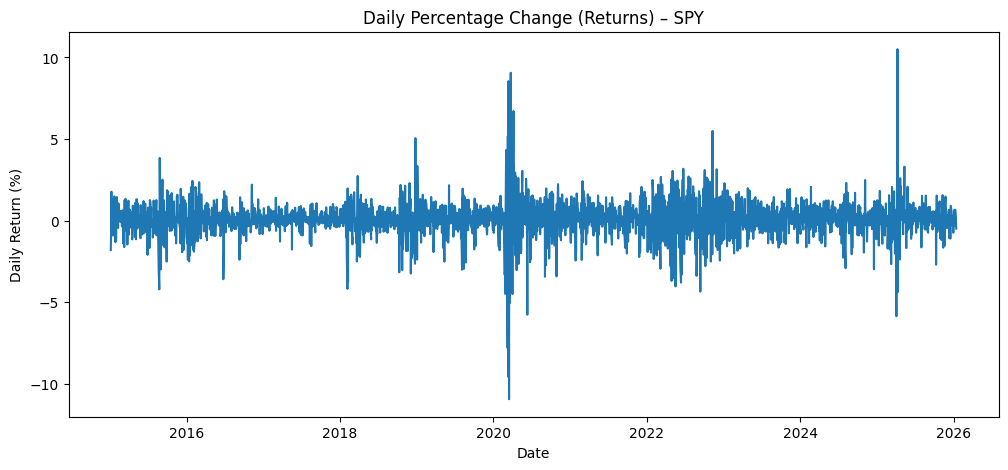

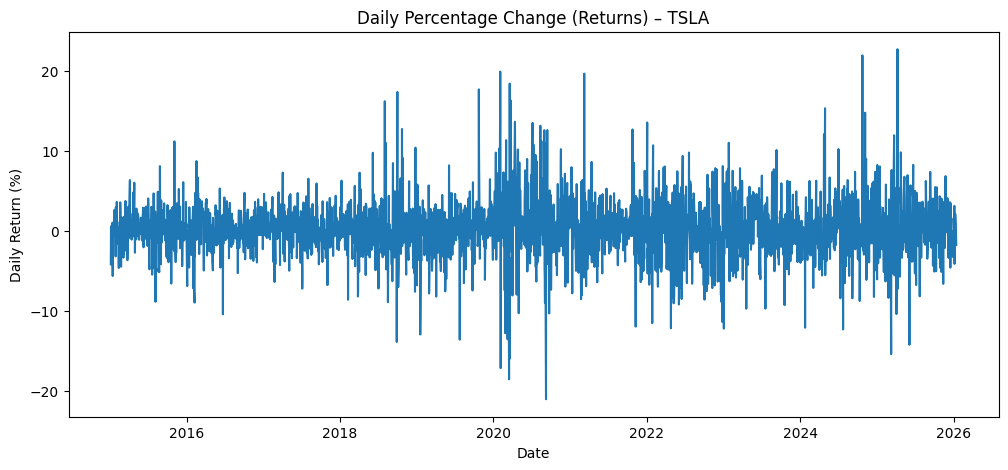

In [17]:
for ticker in df_long["Ticker"].unique():
    subset = df_long[df_long["Ticker"] == ticker]
    
    plt.figure(figsize=(12, 5))
    plt.plot(subset["Date"], subset["Daily_Return"])
    plt.title(f"Daily Percentage Change (Returns) – {ticker}")
    plt.xlabel("Date")
    plt.ylabel("Daily Return (%)")
    plt.show()

### Analyze Volatility: Calculate Rolling Means and Rolling Standard Deviations

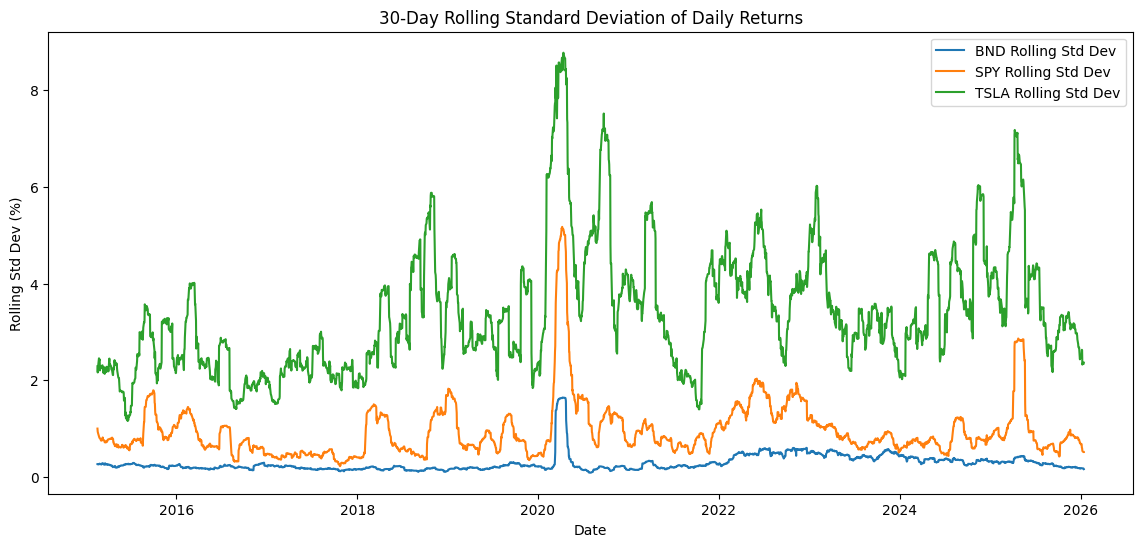

In [18]:
window = 30

df_long['Rolling_Mean'] = df_long.groupby('Ticker')['Daily_Return'].transform(lambda x: x.rolling(window).mean())
df_long['Rolling_Std'] = df_long.groupby('Ticker')['Daily_Return'].transform(lambda x: x.rolling(window).std())

plt.figure(figsize=(14, 6))
for ticker in df_long['Ticker'].unique():
    subset = df_long[df_long['Ticker'] == ticker]
    plt.plot(subset['Date'], subset['Rolling_Std'], label=f'{ticker} Rolling Std Dev')
plt.title(f'{window}-Day Rolling Standard Deviation of Daily Returns')
plt.xlabel('Date')
plt.ylabel('Rolling Std Dev (%)')
plt.legend()
plt.show()


### Outlier Detection: Identify Significant Anomalies in Returns

In [19]:
df_long['Outlier'] = False

for ticker in df_long['Ticker'].unique():
    mask = df_long['Ticker'] == ticker
    rolling_mean = df_long.loc[mask, 'Rolling_Mean']
    rolling_std = df_long.loc[mask, 'Rolling_Std']
    returns = df_long.loc[mask, 'Daily_Return']
    
    outlier_mask = (returns > rolling_mean + 3 * rolling_std) | (returns < rolling_mean - 3 * rolling_std)
    df_long.loc[mask, 'Outlier'] = outlier_mask

# Show some outliers
print(df_long[df_long['Outlier']][['Date', 'Ticker', 'Daily_Return']].head(10))


           Date Ticker  Daily_Return
232  2015-12-03    BND     -0.774522
357  2016-06-03    BND      0.627863
468  2016-11-09    BND     -0.988906
856  2018-05-29    BND      0.695084
1152 2019-08-01    BND      0.716117
1304 2020-03-10    BND     -1.344454
1305 2020-03-11    BND     -1.893970
1306 2020-03-12    BND     -5.438434
1307 2020-03-13    BND      4.220063
1411 2020-08-11    BND     -0.347262


### Analyze Days with Unusually High or Low Returns

In [20]:
window = 30

df_long["Rolling_Mean"] = (
    df_long.groupby("Ticker")["Daily_Return"]
    .transform(lambda x: x.rolling(window).mean())
)

df_long["Rolling_Std"] = (
    df_long.groupby("Ticker")["Daily_Return"]
    .transform(lambda x: x.rolling(window).std())
)

df_long["Outlier"] = False

for ticker in df_long["Ticker"].unique():
    mask = df_long["Ticker"] == ticker
    
    df_long.loc[mask, "Outlier"] = (
        (df_long.loc[mask, "Daily_Return"] >
         df_long.loc[mask, "Rolling_Mean"] + 3 * df_long.loc[mask, "Rolling_Std"])
        |
        (df_long.loc[mask, "Daily_Return"] <
         df_long.loc[mask, "Rolling_Mean"] - 3 * df_long.loc[mask, "Rolling_Std"])
    )


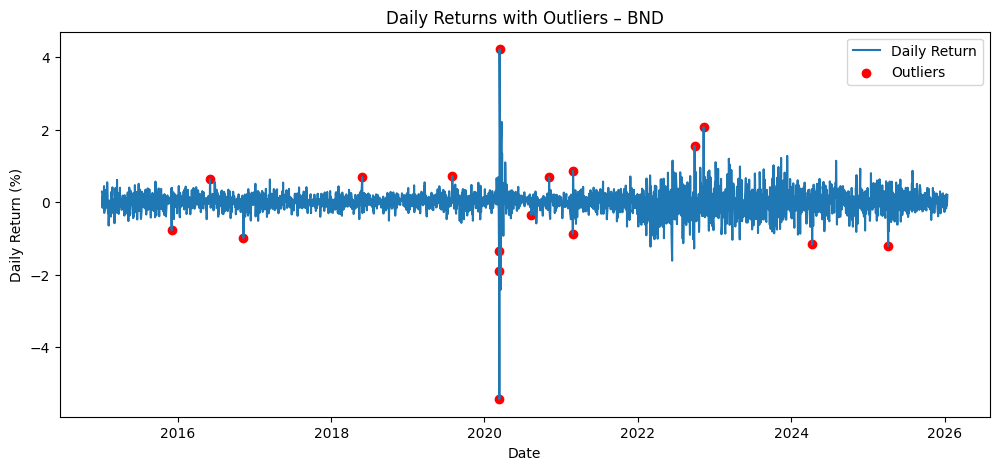

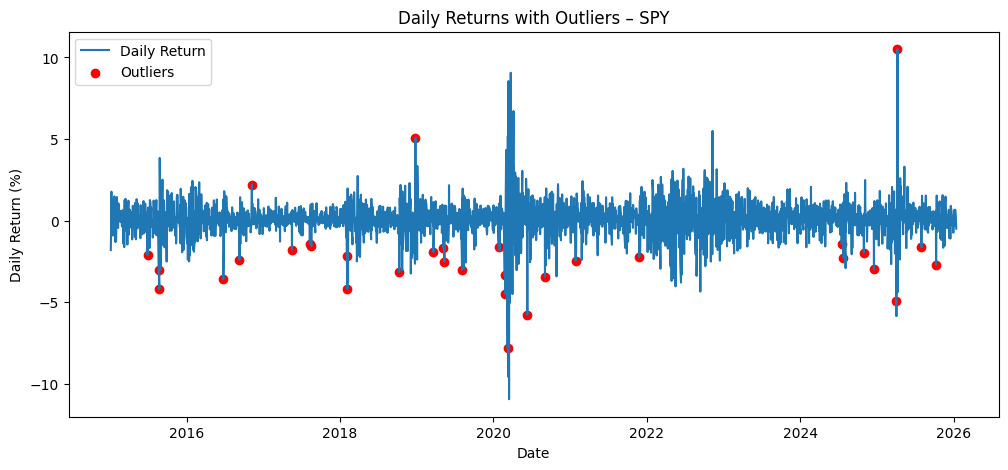

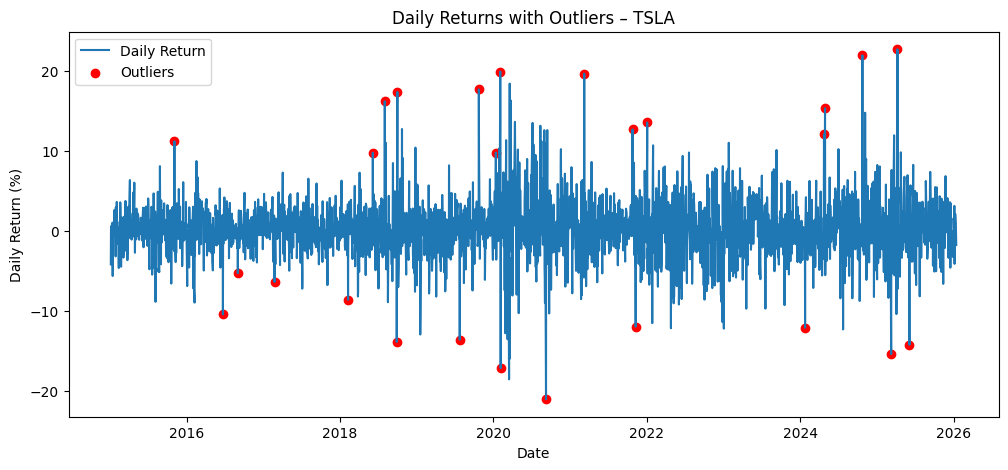

In [21]:
for ticker in df_long["Ticker"].unique():
    subset = df_long[df_long["Ticker"] == ticker]
    outliers = subset[subset["Outlier"]]
    
    plt.figure(figsize=(12, 5))
    plt.plot(subset["Date"], subset["Daily_Return"], label="Daily Return")
    plt.scatter(outliers["Date"], outliers["Daily_Return"], color='red', label="Outliers")
    plt.title(f"Daily Returns with Outliers – {ticker}")
    plt.xlabel("Date")
    plt.ylabel("Daily Return (%)")
    plt.legend()
    plt.show()


## Seasonality and Trend Analysis

### Implement ADF test on Closing Prices and Daily Returns

In [22]:
def adf_test(series, series_name):
    series = series.dropna()
    result = adfuller(series)
    
    print(f"\nADF Test for {series_name}")
    print("-" * 40)
    print(f"ADF Statistic : {result[0]:.4f}")
    print(f"p-value       : {result[1]:.4f}")
    
    for key, value in result[4].items():
        print(f"Critical Value ({key}) : {value:.4f}")


#### ADF test on Adj Close prices

In [23]:
for ticker in df_long["Ticker"].unique():
    prices = df_long[df_long["Ticker"] == ticker]["Adj Close"]
    adf_test(prices, f"{ticker} - Adj Close")



ADF Test for BND - Adj Close
----------------------------------------
ADF Statistic : -1.0514
p-value       : 0.7341
Critical Value (1%) : -3.4327
Critical Value (5%) : -2.8626
Critical Value (10%) : -2.5673

ADF Test for SPY - Adj Close
----------------------------------------
ADF Statistic : 1.1709
p-value       : 0.9958
Critical Value (1%) : -3.4327
Critical Value (5%) : -2.8626
Critical Value (10%) : -2.5673

ADF Test for TSLA - Adj Close
----------------------------------------
ADF Statistic : -0.7802
p-value       : 0.8249
Critical Value (1%) : -3.4327
Critical Value (5%) : -2.8626
Critical Value (10%) : -2.5673


#### Run ADF test on Daily Returns

In [24]:
for ticker in df_long["Ticker"].unique():
    returns = df_long[df_long["Ticker"] == ticker]["Daily_Return"]
    adf_test(returns, f"{ticker} - Daily Returns")



ADF Test for BND - Daily Returns
----------------------------------------
ADF Statistic : -10.4337
p-value       : 0.0000
Critical Value (1%) : -3.4327
Critical Value (5%) : -2.8626
Critical Value (10%) : -2.5673

ADF Test for SPY - Daily Returns
----------------------------------------
ADF Statistic : -17.2288
p-value       : 0.0000
Critical Value (1%) : -3.4327
Critical Value (5%) : -2.8626
Critical Value (10%) : -2.5673

ADF Test for TSLA - Daily Returns
----------------------------------------
ADF Statistic : -53.0196
p-value       : 0.0000
Critical Value (1%) : -3.4327
Critical Value (5%) : -2.8626
Critical Value (10%) : -2.5673


#### Results Interpretation

📉 Closing Prices (Adj Close)

📊 Daily Returns

## Calculate Risk Metrics

### Value at Risk (VaR) & Sharpe Ratio Calculation

In [25]:
var_results = []

for ticker in df_long["Ticker"].unique():
    
    df = df_long[df_long["Ticker"] == ticker].copy()
    df = df.sort_values("Date")
    
    # Daily returns
    df["daily_return"] = df["Adj Close"].pct_change()
    df = df.dropna()
    
    # Historical VaR at 95%
    var_95 = np.percentile(df["daily_return"], 5)
    
    var_results.append({
        "Ticker": ticker,
        "VaR_95": var_95
    })

var_df = pd.DataFrame(var_results)
print("=== Value at Risk (95%) ===")
print(var_df)


=== Value at Risk (95%) ===
  Ticker    VaR_95
0    BND -0.004797
1    SPY -0.016744
2   TSLA -0.052544


In [26]:
# Make sure data is sorted
df = df_long.sort_values(["Ticker", "Date"]).copy()

# Daily returns using Adjusted Close
df["daily_return"] = df.groupby("Ticker")["Adj Close"].pct_change()

# Drop first NaN per ticker
df = df.dropna()

# ===== Value at Risk (95%) =====
var_95 = (
    df.groupby("Ticker")["daily_return"]
      .apply(lambda x: np.percentile(x, 5))
      .reset_index(name="VaR_95")
)

# ===== Sharpe Ratio (historical, risk-free rate = 0) =====
sharpe_ratio = (
    df.groupby("Ticker")["daily_return"]
      .apply(lambda x: x.mean() / x.std())
      .reset_index(name="Sharpe_Ratio")
)

print("=== Value at Risk (95%) ===")
print(var_95)

print("\n=== Sharpe Ratio ===")
print(sharpe_ratio)


=== Value at Risk (95%) ===
  Ticker    VaR_95
0    BND -0.004797
1    SPY -0.016744
2   TSLA -0.052544

=== Sharpe Ratio ===
  Ticker  Sharpe_Ratio
0    BND      0.023805
1    SPY      0.050398
2   TSLA      0.052898


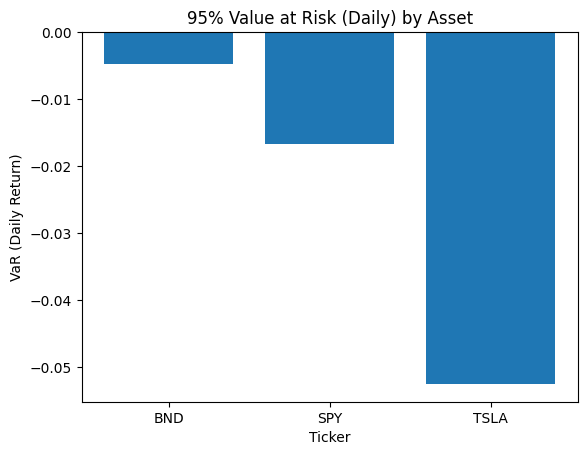

In [27]:
plt.figure()
plt.bar(var_95["Ticker"], var_95["VaR_95"])
plt.title("95% Value at Risk (Daily) by Asset")
plt.xlabel("Ticker")
plt.ylabel("VaR (Daily Return)")
plt.show()


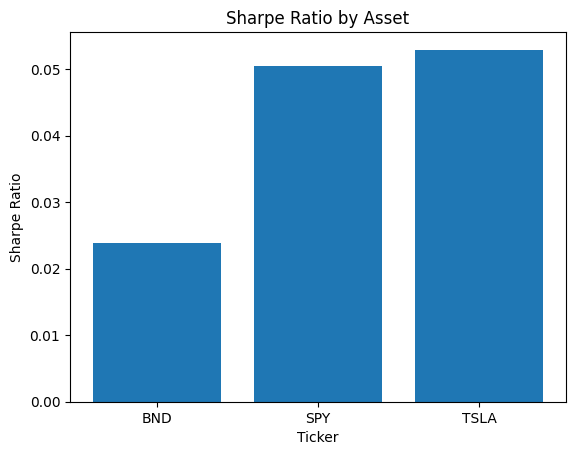

In [28]:
plt.figure()
plt.bar(sharpe_ratio["Ticker"], sharpe_ratio["Sharpe_Ratio"])
plt.title("Sharpe Ratio by Asset")
plt.xlabel("Ticker")
plt.ylabel("Sharpe Ratio")
plt.show()
